In [1]:
import warnings
warnings.filterwarnings(action='ignore') #warnings.filterwarnings(action='default')

from collections import Counter
from datetime import datetime
from pandas import Series

from scipy.stats.stats import kendalltau
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib
import datetime
import string
import math
import re

#setting font
plt.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

### Loading dataset ###

In [2]:
tag = pd.read_table('discipline.txt',sep='\t', header=None)
tag = tag.reset_index(drop=True).reset_index()
tag[3] = tag.apply(lambda x : x['index']+11, axis = 1)
tag.columns = ['index', 'field_id', 'field', 'id2', 'id1']

tag['field'] =  tag['field'].str.capitalize()
tag['field'] = tag['field'].str.replace("science", "Science")

tag0 = dict(zip(tag.field, tag.id2))
tag1 = dict(zip(tag.id1, tag.field))
tag2 = dict(zip(tag.id1, tag.id2))

In [3]:
df_var = pd.read_table("effect_var.txt")

In [4]:
##loading offline dataset
offline = pd.read_table('offline_0627.txt')

offline = offline.loc[offline['author_n']<= 50, :]
offline = offline.loc[offline['paper_type']==2, :]
offline = offline.loc[offline['field_id1'].notnull(), :]

offline["ye_mo"] = offline.apply(lambda x : 10*x['year1']+x['month1'], axis = 1)
offline.rename(columns = {'year1': 'year'}, inplace = True)

author_role = pd.read_table('author_role_plot_0627.txt')
author_role.rename(columns = {'year1': 'year'}, inplace = True)
author_role = author_role[['paperid', 'authorid', 'year', 'field_id1', 'gender', 'author_role']]

### Figure 1 and supplementary 1 ###

In [5]:
### CID in number of papers ###
def did_cal(df):
    paperid = df.groupby(['field_id1', 'year']).count()[['paperid']].reset_index()

    sub_df = pd.DataFrame()
    for i in range(11, 30):
        sub_f = paperid.loc[paperid['field_id1']==i, :].reset_index(drop=True)
        sub_f.loc['2020'] = (sub_f.loc[4][2:][0] - sub_f.loc[3][2:][0]) - (sub_f.loc[3][2:][0] - sub_f.loc[2][2:][0])
        sub_f.loc['2019'] = (sub_f.loc[3][2:][0] - sub_f.loc[2][2:][0]) - (sub_f.loc[2][2:][0] - sub_f.loc[1][2:][0])
        sub_f.loc['2018'] = (sub_f.loc[2][2:][0] - sub_f.loc[1][2:][0]) - (sub_f.loc[1][2:][0] - sub_f.loc[0][2:][0])
        sub_f.loc['2020_1'] = (sub_f.loc[4][2:][0] - sub_f.loc[3][2:][0]) - (sub_f.loc[2][2:][0] - sub_f.loc[1][2:][0])
        sub_f.loc['2019_1'] = (sub_f.loc[3][2:][0] - sub_f.loc[2][2:][0]) - (sub_f.loc[1][2:][0] - sub_f.loc[0][2:][0])
        sub_f.loc['1819'] = sub_f.iloc[6:8, 2:].mean()[0]
        sub_f = sub_f.reset_index()

        sub_f = sub_f.iloc[5:]
        sub_f['field'] = i
        sub_df = pd.concat([sub_df, sub_f])

    sub_df['%'] = round(sub_df['paperid'], 0)
    sub_df = sub_df[['index','%','field']]

    return sub_df

### CID in average number of authors ###
def did_cal_author_n(offline):
    df2 = offline[['field_id1', 'year', 'author_n']]
    author_n = df2.groupby(['field_id1', 'year']).mean().reset_index()

    sub_df = pd.DataFrame()
    for i in range(11, 30):
        sub_f = author_n.loc[author_n['field_id1']==i, :].reset_index(drop=True)
        sub_f.loc['2020'] = (sub_f.loc[4][2:][0] - sub_f.loc[3][2:][0]) - (sub_f.loc[3][2:][0] - sub_f.loc[2][2:][0])
        sub_f.loc['2019'] = (sub_f.loc[3][2:][0] - sub_f.loc[2][2:][0]) - (sub_f.loc[2][2:][0] - sub_f.loc[1][2:][0])
        sub_f.loc['2018'] = (sub_f.loc[2][2:][0] - sub_f.loc[1][2:][0]) - (sub_f.loc[1][2:][0] - sub_f.loc[0][2:][0])
        sub_f.loc['2020_1'] = (sub_f.loc[4][2:][0] - sub_f.loc[3][2:][0]) - (sub_f.loc[2][2:][0] - sub_f.loc[1][2:][0])
        sub_f.loc['2019_1'] = (sub_f.loc[3][2:][0] - sub_f.loc[2][2:][0]) - (sub_f.loc[1][2:][0] - sub_f.loc[0][2:][0])
        sub_f.loc['1819'] = sub_f.iloc[6:8, 2:].mean()[0]
        sub_f = sub_f.reset_index()

        sub_f = sub_f.iloc[5:]
        sub_f['field'] = i
        sub_df = pd.concat([sub_df, sub_f])

    sub_df['%'] = round(sub_df['author_n'], 3)
    sub_df = sub_df[['index','%','field']]
    
    return sub_df

### drawing figure1 ###
def graph_did1(graph, x1, y1, x3, y3, ax1):
    sns.set(style = "ticks", font_scale=1.6)

    g3 = sns.scatterplot(data=graph, x=x3, y=y3, s=150, marker='s', edgecolor='royalblue', linewidth=3, facecolor="w", alpha=0.8, ax=ax1)

    g1 = sns.scatterplot(data=graph, x=x1, y=y1, s=150, marker='o',  edgecolor='orange', linewidth=3, facecolor="w", ax=ax1)

    ax1.axvline(0, c='black', ls='-')
    ax1.axhline(0, c='black', ls='-')

    ax1.set_title("CID in Average Number of Authors(x) vs Number of Papers(y) by Field")

    ax1.set_ylabel("Number of Papers")
    ax1.set_xlabel("Average Number of Authors")
 
    blue_line = mlines.Line2D([], [], color='royalblue', linestyle='', markersize=15, label='2019', marker='s', 
                                fillstyle='none', markeredgewidth=3)
    orange_line = mlines.Line2D([], [], color='orange',linestyle='', markersize=15, label='2020', marker='o', 
                               fillstyle='none', markeredgewidth=3)
    
    L = ax1.legend(handles=[blue_line, orange_line], ncol=3, fontsize=20, frameon=False, bbox_to_anchor=(0.41, -0.18), handletextpad=0.3)

    ax1.grid()

In [6]:
df = offline[['paperid', 'field_id1', 'year', 'author_n', 'female_have', 'female_first', 'female_last']]

paper = did_cal(df)
paper['cat'] = 'paper'
author = did_cal_author_n(offline)
author['cat'] = 'author'
graph = pd.concat([paper, author])

graph['index_year'] = graph['index'] +'_' +graph['cat']
graph['field'] = graph['field'].replace(tag1)

graph = graph.pivot(index='field', columns='index_year', values='%').reset_index()

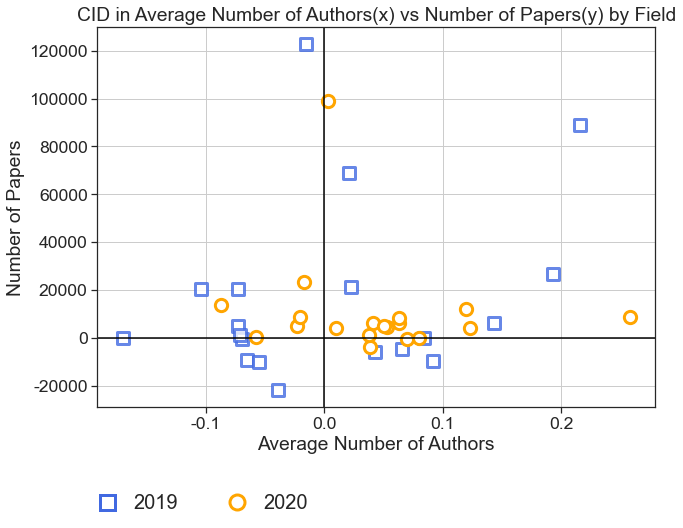

In [8]:
### figure1 ###
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(1, 1, 1) 

graph_did1(graph, '2020_author', '2020_paper', '2019_author', '2019_paper', ax1)

In [31]:
### drawing supplementary figure1 ###

def graph_did_sup_a(graph, x1, y1, x3, y3, ax1):
    sns.set(style = "ticks", font_scale=1.6)

    g3 = sns.scatterplot(data=graph, x=x3, y=y3, s=150, marker='s', edgecolor='royalblue', linewidth=3, facecolor="w", alpha=0.8, ax=ax1)
    for i in range(graph.shape[0]):
        g3.text(x=graph[x3][i]+0.01,y=graph[y3][i]+0.01,s=graph['field'][i],
                       fontdict = dict(color='black' ,size=15))

    g1 = sns.scatterplot(data=graph, x=x1, y=y1, s=150, marker='o',  edgecolor='orange', linewidth=3, facecolor="w", ax=ax1)
    for i in range(graph.shape[0]):
        g1.text(x=graph[x1][i]+0.01,y=graph[y1][i]+0.01,s=graph['field'][i],
                       fontdict = dict(color='black' ,size=15))

    ax1.axvline(0, c='black', ls='-')
    ax1.axhline(0, c='black', ls='-')

    ax1.set_ylabel("Number of Papers")
    ax1.set_xlabel("Average Number of Authors")
 
    blue_line = mlines.Line2D([], [], color='royalblue', linestyle='', markersize=15, label='2019', marker='s', 
                                fillstyle='none', markeredgewidth=3)
    orange_line = mlines.Line2D([], [], color='orange',linestyle='', markersize=15, label='2020', marker='o', 
                               fillstyle='none', markeredgewidth=3)
    ax1.grid()
    
def graph_did_sup_b(graph, x1, y1, x2, y2, ax1):
    sns.set(style = "ticks", font_scale=1.6)

    g2 = sns.scatterplot(data=graph, x=x2, y=y2, s=150, marker='^', edgecolor='silver', linewidth=3, facecolor="w", alpha=0.8, ax=ax1)

    g1 = sns.scatterplot(data=graph, x=x1, y=y1, s=150, marker='o',  edgecolor='orange', linewidth=3, facecolor="w", ax=ax1)

    ax1.axvline(0, c='black', ls='-')
    ax1.axhline(0, c='black', ls='-')

    ax1.set_ylabel("Number of Papers")
    ax1.set_xlabel("Average Number of Authors")
 
    silver_line = mlines.Line2D([], [], color='silver', linestyle='', markersize=15, label='Average between 2018 and 2019', marker='^', 
                                fillstyle='none', markeredgewidth=3)
    blue_line = mlines.Line2D([], [], color='royalblue', linestyle='', markersize=15, label='2019', marker='s', 
                                fillstyle='none', markeredgewidth=3)
    orange_line = mlines.Line2D([], [], color='orange',linestyle='', markersize=15, label='2020', marker='o', 
                               fillstyle='none', markeredgewidth=3)
    L = ax1.legend(handles=[silver_line, blue_line, orange_line], ncol=3, fontsize=20, frameon=False, bbox_to_anchor=(0.77, -0.23), handletextpad=0.3)
 
    ax1.grid()

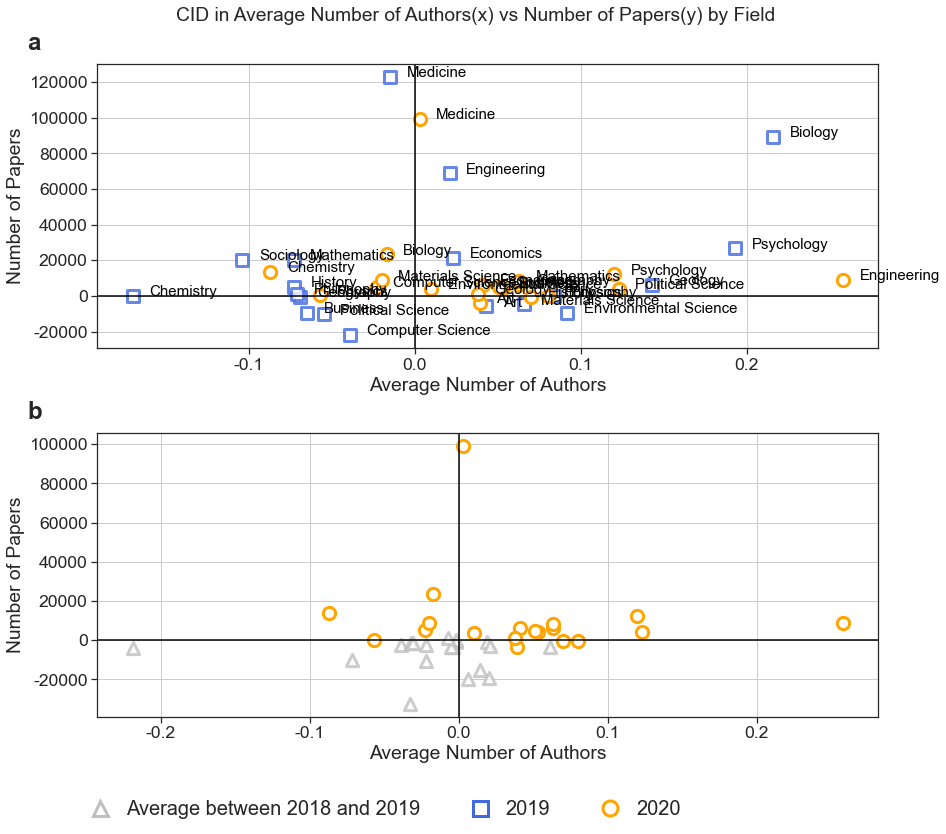

In [32]:
### supplementary figure 1 ###
fig = plt.figure(figsize=(14, 12))
ax1 = fig.add_subplot(2, 1, 1) 
ax2 = fig.add_subplot(2, 1, 2) 

plt.subplots_adjust(hspace=0.3) #wspace=0.35, 

graph_did_sup_a(graph, '2020_author', '2020_paper', '2019_author', '2019_paper', ax1)
graph_did_sup_b(graph, '2020_author', '2020_paper', '1819_author', '1819_paper', ax2)

fig.text(0.5, 0.93, 'CID in Average Number of Authors(x) vs Number of Papers(y) by Field', ha='center')

labellist = [f"{x}" for x in string.ascii_lowercase]
for idx, now_ax in enumerate(fig.get_axes()):
    now_ax.text(-0.09, 1.05, labellist[idx], fontsize=24, weight='bold', transform=now_ax.transAxes)

### Figure 2 and supplementary figure 2,3 ###

In [86]:
### CID by author role in total cases
def cal_female_per(df, female_have):
    fe = df[['year', female_have, 'paperid']]
    fe = fe.groupby(['year', female_have]).count()
    fe['sum'] = fe.groupby(['year']).transform(sum)
    fe['%'] = round(fe['paperid']/fe['sum']*100, 2)

    fe =  fe.reset_index()
    fe = fe.loc[fe[female_have]==1, :][['year', 'paperid', '%']]
    fe = fe.sort_values(by=['year'], axis=0)
    
    fe['author role'] = female_have
    fe = fe[['year', '%', 'author role']]
    
    fe = fe.reset_index(drop=True)
    fe.loc['2020'] = (fe.loc[4][1:][0] - fe.loc[3][1:][0]) - (fe.loc[3][1:][0] - fe.loc[2][1:][0])
    fe.loc['2019'] = (fe.loc[3][1:][0] - fe.loc[2][1:][0]) - (fe.loc[2][1:][0] - fe.loc[1][1:][0])
    fe.loc['2018'] = (fe.loc[2][1:][0] - fe.loc[1][1:][0]) - (fe.loc[1][1:][0] - fe.loc[0][1:][0])
    fe.loc['2020_1'] = (fe.loc[4][1:][0] - fe.loc[3][1:][0]) - (fe.loc[2][1:][0] - fe.loc[1][1:][0])
    fe.loc['2019_1'] = (fe.loc[3][1:][0] - fe.loc[2][1:][0]) - (fe.loc[1][1:][0] - fe.loc[0][1:][0])
    fe.loc['1819'] = fe.iloc[6:8, 1:].mean()[0]

    fe = fe.reset_index()
    fe = fe.iloc[5:, 0:]
    fe['author role'] = female_have
    
    return fe

### drawing figure 2_a ###
def show_value_for_barplot(barplot, h_v="v"):
    if h_v == "v":
        for p in barplot.patches:
            barplot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    elif h_v == "h":
        for p in barplot.patches:
            barplot.annotate(format(p.get_width(), '.2f'), (p.get_width(), p.get_y()+ p.get_height() / 2.), ha = 'center', va = 'center', xytext = (18, 0), textcoords = 'offset points')

            
def graph_did2_a(female2, ax1):
    sns.set(style = "ticks", font_scale=2.0)

    sns.barplot(x ='DID', y = 'Female Author Role', hue = 'index', data = female2,  orient='h', ci= False, ax = ax1)
    ax1.grid()

    ax1.set_xlim([-0.5,0.5])
    ax1.axvline(0, c='black', ls='-')

    for y1 in range(0, 4):
        ax1.patches[y1].set_facecolor('royalblue')
    for y2 in range(4, 8):
        ax1.patches[y2].set_facecolor('orange')

    ax1.set_xlabel('CID')
    ax1.set_title('Total Data')
    show_value_for_barplot(ax1, h_v="h")
    ax1.get_legend().remove()

In [82]:
### CID by field ###
def cal_female_per_byfield(df, female_have):
    fe = df[['year', 'field_id1', female_have, 'paperid']]
    fe = fe.groupby(['year', 'field_id1', female_have]).count()
    fe['sum'] = fe.groupby(['year', 'field_id1']).transform(sum)
    fe['%'] = round(fe['paperid']/fe['sum']*100, 2)

    fe =  fe.reset_index()
    fe = fe.loc[fe[female_have]==1, :][['year', 'field_id1', 'paperid', '%']]
    fe = fe.sort_values(by=['field_id1', 'year'], axis=0)
    fe['field_id1'] = fe['field_id1'].replace(tag1)

    fe = fe.pivot(columns='field_id1',index=['year']).fillna(0)
    
    return fe

### drawing figure 2_b ###
def graph_did2_b(x1, y1, x2, y2, ax1):
    sns.set(style = "ticks", font_scale=2.0)
    
    g2 = sns.scatterplot(data=cross, x=x2, y=y2, s=150, marker='s', edgecolor='royalblue', linewidth=3, facecolor="w", alpha=0.8, ax=ax1)

    g1 = sns.scatterplot(data=cross, x=x1, y=y1, s=200, marker='o',  edgecolor='orange', linewidth=3, facecolor="w", ax=ax1)
    an_df = cross.loc[(cross[x1]>=0), :].reset_index(drop=True)
    for i in range(an_df.shape[0]):
        g1.text(x=an_df[x1][i]+0.05,y=an_df[y1][i]+0.05,s=an_df['field_id1'][i],
                       fontdict = dict(color='black' ,size=18))

    plt.axvline(0, c='black', ls='-')
    plt.axhline(0, c='black', ls='-')

    plt.title("CID in % First Author(x) vs Last Author(y) by Field", fontsize=24)

    plt.xlabel("First Author")
    plt.ylabel("Last Author")

    plt.grid()

In [60]:
df = offline[['paperid', 'field_id1', 'year', 'female_have', 'female_first', 'female_last']]

fe_other = author_role.loc[author_role['author_role'] == '기타', :]
fe_other = fe_other.groupby(['paperid']).sum().reset_index()
fe_other.rename(columns = {'gender': 'female_other'}, inplace = True)

fe_other = fe_other[['paperid', 'female_other']]
fe_other["female_other"] = fe_other.apply(lambda x : 0 if x['female_other']==0 else 1, axis = 1)

df = pd.merge(df, fe_other, on='paperid', how='left')

In [83]:
### calculating figure 2_a ###
fe_hav = cal_female_per(df, 'female_have')
fe_fir = cal_female_per(df, 'female_first')
fe_las = cal_female_per(df, 'female_last')
fe_other2 = cal_female_per(df, 'female_other')

female = pd.concat([fe_hav, fe_fir, fe_las, fe_other2])

female.loc[female['author role']=='female_have', 'author role'] = 'Any'
female.loc[female['author role']=='female_first', 'author role'] = 'First'
female.loc[female['author role']=='female_last', 'author role'] = 'Last'
female.loc[female['author role']=='female_other', 'author role'] = 'Others'

female.rename(columns = {'author role': 'Female Author Role', '%': 'DID'}, inplace = True)

female2 = female.loc[(female['index']=='2020')|(female['index']=='2019'), :]

female2 = female2.sort_values("index")
female2 = female2.reset_index(drop=True)

In [62]:
### calculating figure 2_b ###
fe_hav = cal_female_per_byfield(df, 'female_have')
fe_fir = cal_female_per_byfield(df, 'female_first')
fe_las = cal_female_per_byfield(df, 'female_last')

female_2_b = pd.concat([fe_hav, fe_fir, fe_las])

percent = female_2_b['%'][['History', 'Philosophy', 'Art', 'Economics', 'Sociology', 'Political Science', 'Psychology', 'Business', 'Chemistry', 
                       'Materials Science', 'Computer Science', 'Engineering', 'Geology', 'Geography', 'Mathematics', 'Biology', 
                       'Environmental Science', 'Physics', 'Medicine']].reset_index()
paperid = female_2_b['paperid'][['History', 'Philosophy', 'Art', 'Economics', 'Sociology', 'Political Science', 'Psychology', 'Business', 'Chemistry',
                       'Materials Science', 'Computer Science', 'Engineering', 'Geology', 'Geography', 'Mathematics', 'Biology', 
                       'Environmental Science', 'Physics', 'Medicine']].reset_index()

female_2_b = pd.concat([percent, paperid])
field_box = female_2_b.iloc[5:15]

#female first
field_box = female_2_b.iloc[5:15]
field_box.loc['2020_first'] = (field_box.loc[9] - field_box.loc[8]) - (field_box.loc[8] - field_box.loc[7])
field_box.loc['2019_first'] = (field_box.loc[8] - field_box.loc[7]) - (field_box.loc[7] - field_box.loc[6])
field_box.loc['2018_first'] = (field_box.loc[7] - field_box.loc[6]) - (field_box.loc[6] - field_box.loc[5])
field_box.loc['2020_1_first'] = (field_box.loc[9] - field_box.loc[8]) - (field_box.loc[7] - field_box.loc[6])
field_box.loc['2019_1_first'] = (field_box.loc[8] - field_box.loc[7]) - (field_box.loc[6] - field_box.loc[5])
field_box.loc['1819_first'] = field_box.iloc[11:13, 1:].mean()
female_first = field_box.iloc[10:, 1:].T

#female last
field_box = female_2_b.iloc[5:15]
field_box.loc['2020_last'] = (field_box.loc[14] - field_box.loc[13]) - (field_box.loc[13] - field_box.loc[12])
field_box.loc['2019_last'] = (field_box.loc[13] - field_box.loc[12]) - (field_box.loc[12] - field_box.loc[11])
field_box.loc['2018_last'] = (field_box.loc[12] - field_box.loc[11]) - (field_box.loc[11] - field_box.loc[10])
field_box.loc['2020_1_last'] = (field_box.loc[14] - field_box.loc[13]) - (field_box.loc[12] - field_box.loc[11])
field_box.loc['2019_1_last'] = (field_box.loc[13] - field_box.loc[12]) - (field_box.loc[11] - field_box.loc[10])
field_box.loc['1819_last'] = field_box.iloc[11:13, 1:].mean()
female_last = field_box.iloc[10:, 1:].T

cross = pd.concat([female_first, female_last], axis=1)
cross = cross.reset_index()

In [ ]:
### figure 2 ###
fig = plt.figure(constrained_layout=True, figsize=(18, 8))
spec = gridspec.GridSpec(ncols=14, nrows=15, figure=fig)

ax1 = fig.add_subplot(spec[0:15, 0:5])
ax2 = fig.add_subplot(spec[0:15, 6:15])

graph_did2_a(female2, ax1)
handles, labels = ax1.get_legend_handles_labels()
L = ax1.legend(ncol=2, fontsize=24, bbox_to_anchor=(0.89, -0.18), frameon=False) #handles = []

graph_did2_b('2020_first', '2020_last', '2019_first', '2019_last', ax2)
blue_line = mlines.Line2D([], [], color='royalblue', linestyle='', markersize=15, label='2019', marker='s', 
                            fillstyle='none', markeredgewidth=3)
orange_line = mlines.Line2D([], [], color='orange',linestyle='', markersize=15, label='2020', marker='o', 
                           fillstyle='none', markeredgewidth=3)
                        
L = ax2.legend(handles=[blue_line, orange_line], ncol=3, fontsize=24, frameon=False, bbox_to_anchor=(0.48, -0.18),
              handletextpad=0.3)

labellist = [f"{x}" for x in string.ascii_lowercase]
for idx, now_ax in enumerate(fig.get_axes()):
    now_ax.text(-0.09, 1.02, labellist[idx], fontsize=24, weight='bold', transform=now_ax.transAxes)

In [79]:
### drawing supplementary figure 2_a and 2_b ###
def graph_did_sup_2_a(female2, ax1):
    sns.set(style = "ticks", font_scale=2.0)

    sns.barplot(x ='DID', y = 'Female Author Role', hue = 'index', data = female2,  orient='h', ci= False, ax = ax1)
    ax1.grid()

    ax1.set_xlim([-0.4,0.4])
    ax1.axvline(0, c='black', ls='-')

    for y1 in range(0, 4):
        ax1.patches[y1].set_facecolor('silver')
    for y2 in range(4, 8):
        ax1.patches[y2].set_facecolor('orange')

    ax1.set_xlabel('CID')
    ax1.set_title('Total Data')
    show_value_for_barplot(ax1, h_v="h")
    ax1.get_legend().remove()
    
def graph_did_sup_2_b(x1, y1, x2, y2, ax1):
    sns.set(style = "ticks", font_scale=2.0)
    
    g2 = sns.scatterplot(data=cross, x=x2, y=y2, s=200, marker='^', edgecolor='silver', linewidth=3, facecolor="w", alpha=0.8, ax=ax1)

    g1 = sns.scatterplot(data=cross, x=x1, y=y1, s=200, marker='o',  edgecolor='orange', linewidth=3, facecolor="w", ax=ax1)
    an_df = cross.loc[(cross[x1]>=0), :].reset_index(drop=True)
    for i in range(an_df.shape[0]):
        g1.text(x=an_df[x1][i]+0.05,y=an_df[y1][i]+0.05,s=an_df['field_id1'][i],
                       fontdict = dict(color='black' ,size=18))

    plt.axvline(0, c='black', ls='-')
    plt.axhline(0, c='black', ls='-')

    plt.title("CID in % First Author(x) vs Last Author(y) by Field", fontsize=24)

    plt.xlabel("First Author")
    plt.ylabel("Last Author")

    plt.grid()

In [ ]:
### supplementary figure 2 ###
female_sup2 = female.loc[(female['index']=='2020')|(female['index']=='1819'), :]

female_sup2 = female_sup2.sort_values("index")
female_sup2 = female_sup2.reset_index(drop=True)

fig = plt.figure(constrained_layout=True, figsize=(18, 8))
spec = gridspec.GridSpec(ncols=14, nrows=15, figure=fig)

ax1 = fig.add_subplot(spec[0:15, 0:5])
ax2 = fig.add_subplot(spec[0:15, 6:15])

graph_did_sup_2_a(female_sup2, ax1)
handles, labels = ax1.get_legend_handles_labels()
silver_line = mlines.Line2D([], [], color='silver', linestyle='', markersize=15, label='Average between 2018 and 2019', marker='^', 
                            fillstyle='none', markeredgewidth=3)
orange_line = mlines.Line2D([], [], color='orange',linestyle='', markersize=15, label='2020', marker='o', 
                           fillstyle='none', markeredgewidth=3)         
L = ax1.legend(handles = [silver_line, orange_line], ncol=1, fontsize=24, bbox_to_anchor=(1.1, -0.18), frameon=False) #handles = []

graph_did_sup_2_b('2020_first', '2020_last', '1819_first', '1819_last', ax2)
silver_line = mlines.Line2D([], [], color='silver', linestyle='', markersize=15, label='Average between 2018 and 2019', marker='^', 
                            fillstyle='none', markeredgewidth=3)
orange_line = mlines.Line2D([], [], color='orange',linestyle='', markersize=15, label='2020', marker='o', 
                           fillstyle='none', markeredgewidth=3)                        
L = ax2.legend(handles=[silver_line, orange_line], ncol=1, fontsize=24, frameon=False, bbox_to_anchor=(0.73, -0.18),
              handletextpad=0.3)

labellist = [f"{x}" for x in string.ascii_lowercase]
for idx, now_ax in enumerate(fig.get_axes()):
    now_ax.text(-0.09, 1.02, labellist[idx], fontsize=24, weight='bold', transform=now_ax.transAxes)

In [90]:
### drawing supplementary figure 3 ###
def graph_did_sup3(female2, ax1):
    sns.set(style = "ticks", font_scale=2.0)

    sns.barplot(x ='DID', y = 'Female Author Role', hue = 'index', data = female2,  orient='h', ci= False, ax = ax1)
    ax1.grid()

    ax1.set_xlim([-0.8,0.5])
    ax1.axvline(0, c='black', ls='-')

    for y1 in range(0, 4):
        ax1.patches[y1].set_facecolor('#bcbddc')
    for y2 in range(4, 8):
        ax1.patches[y2].set_facecolor('royalblue')
    for y3 in range(8, 12):
        ax1.patches[y3].set_facecolor('orange')

    ax1.set_xlabel('CID')
    ax1.set_title('Total Data')
    show_value_for_barplot(ax1, h_v="h")
    ax1.get_legend().remove()

In [ ]:
### supplementary figure 3 ###
female_sup3 = female.loc[(female['index']=='2020')|(female['index']=='2019')|(female['index']=='2018'), :]

female_sup3 = female_sup3.sort_values("index")
female_sup3 = female_sup3.reset_index(drop=True)

fig = plt.figure(figsize=(5, 7))
ax1 = fig.add_subplot(1, 1, 1)

graph_did_sup3(female_sup3, ax1)
handles, labels = ax1.get_legend_handles_labels()
L = ax1.legend(ncol=3, fontsize=24, bbox_to_anchor=(1.4, -0.18), frameon=False)

### Figure 3 and supplementary figure 4 ###

In [ ]:
### CID for % female first authors by first-author’s characteristics ###
def did_cal_byvar(df, five, female_have, effect_var):
    df2 = df[['paperid', 'year', 'female_have', 'female_first', 'female_last', five]]
    df2 = df2.loc[df2[five].notnull(), :]

    if effect_var == 'aca_age':
        df2.loc[df2[five]<10, 'set'] = 'set1'
        df2.loc[(df2[five]>=10)&(df2[five]<20), 'set'] = 'set2'
        df2.loc[(df2[five]>=20)&(df2[five]<30), 'set'] = 'set3'
        df2.loc[df2[five]>=30, 'set'] = 'set4'
    elif effect_var == 'aut_hidx':
        df2.loc[df2[five]<2, 'set'] = 'set1'
        df2.loc[(df2[five]>=2)&(df2[five]<4), 'set'] = 'set2'
        df2.loc[(df2[five]>=4)&(df2[five]<8), 'set'] = 'set3'
        df2.loc[df2[five]>=8, 'set'] = 'set4'
    else:
        df2.loc[df2[five]<st[0], 'set'] = 'set1'
        df2.loc[(df2[five]>=st[0])&(df2[five]<st[1]), 'set'] = 'set2'
        df2.loc[(df2[five]>=st[1])&(df2[five]<st[2]), 'set'] = 'set3'
        df2.loc[df2[five]>=st[2], 'set'] = 'set4'

    fe_hav = df2[['year', female_have, 'paperid', 'set']]
    fe_hav = fe_hav.groupby(['year', female_have, 'set']).count()

    fe_hav['sum'] = fe_hav.groupby(['year', 'set']).transform(sum)
    fe_hav['%'] = round(fe_hav['paperid']/fe_hav['sum']*100, 2) #sum: 남자 + 여자

    fe_hav =  fe_hav.reset_index()
    fe_hav = fe_hav.loc[fe_hav[female_have]==1, :][['year', 'set', '%']]
    fe_hav = fe_hav.sort_values(by=['year'], axis=0)

    effect_val = ['set1', 'set2', 'set3', 'set4']

    df3 = pd.DataFrame()
    for x in effect_val:
        did = fe_hav.loc[fe_hav['set']==x, :].reset_index(drop=True)

        did.loc['2018'] = (did.loc[2][2:] - did.loc[1][2:]) - (did.loc[1][2:] - did.loc[0][2:])
        did.loc['2019'] = (did.loc[3][2:] - did.loc[2][2:]) - (did.loc[2][2:] - did.loc[1][2:])
        did.loc['2020'] = (did.loc[4][2:] - did.loc[3][2:]) - (did.loc[3][2:] - did.loc[2][2:])
        did.loc['2020_1'] = (did.loc[4][2:] - did.loc[3][2:]) - (did.loc[2][2:] - did.loc[1][2:])
        did.loc['2019_1'] = (did.loc[3][2:] - did.loc[2][2:]) - (did.loc[1][2:] - did.loc[0][2:])

        did = did.iloc[5:, 2:]
        did['set'] = x
        did['author_role'] = female_have
        did['cat'] = five

        df3 = pd.concat([df3, did])
        
    return df3

In [ ]:
### Calculating CID for % female first authors by first-author’s characteristics ###
effect_var_list = ['aca_age', 'aut_hidx', 'aff_hidx', 'ggis1', 'total_cases_per_million', 'total_deaths_per_million']

var_name_list = ['Academic Age', 'Author h-index', 'Affiliation h-index', 'Gender Equality', 'Total Cases Per Million', 'Total Deaths Per Million']

df_total = pd.DataFrame()

for effect_var in effect_var_list:
    var = df_var[['authorid', effect_var]].dropna(axis=0) #null 제외
    var = var.drop_duplicates()
    var2 = var[effect_var]
    st = list(var2.quantile([.25, .50,.75]))

    df = offline[['paperid', 'year', 'female_have', 'female_first', 'female_last']]

    author_role2 = author_role

    author_role2 = pd.merge(author_role2, var, on='authorid', how='left')

    author_role2 = author_role2.loc[author_role2[effect_var].notnull(), :]

    #최대, 최소, 평균, 제1저자, 교신저자
    fir = author_role2.loc[author_role2['author_role']=='제1', :][['paperid', effect_var]]
    las = author_role2.loc[author_role2['author_role']=='교신', :][['paperid', effect_var]]
    mean_val = author_role2.groupby(['paperid']).mean().reset_index()[['paperid', effect_var]]

    five_val = pd.merge(fir, las, on='paperid', how='left')
    five_val = pd.merge(five_val, mean_val, on='paperid', how='left')
    five_val.columns = ['paperid', 'fir', 'las', 'mean']

    df = pd.merge(df, five_val, on='paperid', how='left')

    five_list = ['fir', 'las', 'mean']

    graph = pd.DataFrame()
    
    for five in five_list:
        gra1 = did_cal_byvar(df, five, 'female_have', effect_var)
        gra2 = did_cal_byvar(df, five, 'female_first', effect_var)
        gra3 = did_cal_byvar(df, five, 'female_last', effect_var)

        graph = pd.concat([graph, gra1, gra2, gra3])
        
        df3_s = pd.DataFrame()

    effect_val = ['set1', 'set2', 'set3', 'set4']

    for i in effect_val:
        df0 = graph.loc[graph['set']==i, :]

        for five in five_list:
            df2_s = df0.loc[df0['cat']==five, :].reset_index()

            df2_s.loc[15] = (df2_s.loc[0][1:2] + df2_s.loc[1][1:2])/2
            df2_s.loc[df2_s['author_role'].isnull(), 'author_role'] = 'female_have'

            df2_s.loc[16] = (df2_s.loc[5][1:2] + df2_s.loc[6][1:2])/2
            df2_s.loc[df2_s['author_role'].isnull(), 'author_role'] = 'female_first'

            df2_s.loc[17] = (df2_s.loc[10][1:2] + df2_s.loc[11][1:2])/2
            df2_s.loc[df2_s['author_role'].isnull(), 'author_role'] = 'female_last'

            df2_s.loc[df2_s['index'].isnull(), 'index'] = '1819'
            df2_s['set'] = i
            df2_s['cat'] = five

            df2_s['head'] = df2_s['index'] +"_"+ df2_s['author_role']
            
            df3_s = pd.concat([df3_s, df2_s])

    df3_s = df3_s.reset_index(drop= True)
    df3_s['head'] = df3_s['author_role'] + ":" +df3_s['cat']

    df3_s.rename(columns = {'%': 'DID', 'set':'SET'}, inplace = True)

    df3_s.loc[df3_s['SET']=='set1', 'SET'] = 'Group1'
    df3_s.loc[df3_s['SET']=='set2', 'SET'] = 'Group2'
    df3_s.loc[df3_s['SET']=='set3', 'SET'] = 'Group3'
    df3_s.loc[df3_s['SET']=='set4', 'SET'] = 'Group4'
    
    df3_s = df3_s.loc[df3_s['head']=='female_first:fir', :] ### 
    df3_s['effect_var'] = effect_var
    
    df_total = pd.concat([df_total, df3_s])
    
    print(effect_var)

In [121]:
### drawing figure 3 ###
def graph_did3(df3, category, var_name, ax_number, set1_ex, set4_ex):
    sns.set(style = "ticks", font_scale=1.6)

    sns_df = df3.loc[df3['effect_var']==category, :]
    sns_df.loc[sns_df['SET']=='Group1', "SET"] = set1_ex
    sns_df.loc[sns_df['SET']=='Group4', "SET"] = set4_ex

    sns.barplot(x ='DID', y = 'SET', hue = 'index', data = sns_df,  orient='h', ci= False, ax=ax_number)
    ax_number.grid()

    ax_number.set_xlim([-1, 0.5]) #offline: -3, 3
    ax_number.axvline(0, c='black', ls='-')

    for y1 in range(0, 4):
        ax_number.patches[y1].set_facecolor('royalblue')  
    for y2 in range(4, 8):
        ax_number.patches[y2].set_facecolor('orange')
        
    ax_number.set(xlabel=None)
    ax_number.set(ylabel=None)

    ax_number.set_title(var_name)
    show_value_for_barplot(ax_number,h_v="h")
    
    ax_number.get_legend().remove()

In [ ]:
### figure 3 ###
df_total2 = df_total.loc[(df_total['index']=='2020')|(df_total['index']=='2019')]
df_total2 = df_total2.sort_values(['index', 'SET'])

fig = plt.figure(figsize=(16, 13))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

plt.subplots_adjust(wspace=0.35, hspace=0.25)

graph_did3(df_total2, effect_var_list[0], var_name_list[0], ax1, 'Group1\n(Early)', 'Group4\n(Late)')
graph_did3(df_total2, effect_var_list[1], var_name_list[1], ax2, 'Group1\n(Low)', 'Group4\n(High)')
graph_did3(df_total2, effect_var_list[2], var_name_list[2], ax3, 'Group1\n(Low)', 'Group4\n(High)')
graph_did3(df_total2, effect_var_list[3], var_name_list[3], ax4, 'Group1\n(Low)', 'Group4\n(High)')
graph_did3(df_total2, effect_var_list[4], var_name_list[4], ax5, 'Group1\n(Small)', 'Group4\n(Large)')
graph_did3(df_total2, effect_var_list[5], var_name_list[5], ax6, 'Group1\n(Small)', 'Group4\n(Large)')

sns.set(style = "ticks", font_scale=1.6)
    
handles, labels = ax4.get_legend_handles_labels()
L = ax4.legend(ncol=3, fontsize=20, bbox_to_anchor=(1.07, -0.18), frameon=False)

labellist = [f"{x}" for x in string.ascii_lowercase]
for idx, now_ax in enumerate(fig.get_axes()):
    now_ax.text(-0.15, 1.02, labellist[idx], fontsize=20, weight='bold', transform=now_ax.transAxes) #

In [130]:
### drawing supplementary figure 4 ###
def graph_did3_sup4(df3, category, var_name, ax_number, set1_ex, set4_ex):
    sns.set(style = "ticks", font_scale=1.6)

    sns_df = df3.loc[df3['effect_var']==category, :]
    sns_df.loc[sns_df['SET']=='Group1', "SET"] = set1_ex
    sns_df.loc[sns_df['SET']=='Group4', "SET"] = set4_ex

    sns.barplot(x ='DID', y = 'SET', hue = 'index', data = sns_df,  orient='h', ci= False, ax=ax_number)
    ax_number.grid()

    ax_number.set_xlim([-1, 0.5]) #offline: -3, 3
    ax_number.axvline(0, c='black', ls='-')

    for y1 in range(0, 4):
        ax_number.patches[y1].set_facecolor('silver')  
    for y2 in range(4, 8):
        ax_number.patches[y2].set_facecolor('orange')
        
    ax_number.set(xlabel=None)
    ax_number.set(ylabel=None)

    ax_number.set_title(var_name)
    show_value_for_barplot(ax_number,h_v="h")
    
    ax_number.get_legend().remove()

In [ ]:
### supplementary figure 4 ###
df_total2 = df_total.loc[(df_total['index']=='2020')|(df_total['index']=='1819')]
df_total2 = df_total2.sort_values(['index', 'SET'])

fig = plt.figure(figsize=(16, 13))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

plt.subplots_adjust(wspace=0.35, hspace=0.25)

graph_did3_sup4(df_total2, effect_var_list[0], var_name_list[0], ax1, 'Group1\n(Early)', 'Group4\n(Late)')
graph_did3_sup4(df_total2, effect_var_list[1], var_name_list[1], ax2, 'Group1\n(Low)', 'Group4\n(High)')
graph_did3_sup4(df_total2, effect_var_list[2], var_name_list[2], ax3, 'Group1\n(Low)', 'Group4\n(High)')
graph_did3_sup4(df_total2, effect_var_list[3], var_name_list[3], ax4, 'Group1\n(Low)', 'Group4\n(High)')
graph_did3_sup4(df_total2, effect_var_list[4], var_name_list[4], ax5, 'Group1\n(Small)', 'Group4\n(Large)')
graph_did3_sup4(df_total2, effect_var_list[5], var_name_list[5], ax6, 'Group1\n(Small)', 'Group4\n(Large)')

sns.set(style = "ticks", font_scale=1.6)
    
handles, labels = ax4.get_legend_handles_labels()
L = ax4.legend(ncol=3, fontsize=20, bbox_to_anchor=(2.1, -0.18), frameon=False)
L.get_texts()[0].set_text('Average between 2018 and 2019')

labellist = [f"{x}" for x in string.ascii_lowercase]
for idx, now_ax in enumerate(fig.get_axes()):
    now_ax.text(-0.15, 1.02, labellist[idx], fontsize=20, weight='bold', transform=now_ax.transAxes) #

### Supplementary figure 5 ###

In [100]:
### CID(%) by percentile for female first authors by h-index of them and their affiliation, respectively ###
def did_per(df, five, female_have):
    df2 = df[['paperid', 'year', 'female_have', 'female_first', 'female_last', five]]
    df2 = df2.loc[df2[five].notnull(), :]
    
    df2['rank'] = df2[five].rank(method='min', ascending=True)
    
    max_val = df2['rank'].max()
    df2['per'] = df2.apply(lambda x : (x['rank']/max_val)*100, axis = 1)

    df2.loc[df2['per']<10, 'set'] = 10
    df2.loc[(df2['per']>=10)&(df2['per']<20), 'set'] = 20
    df2.loc[(df2['per']>=20)&(df2['per']<30), 'set'] = 30
    df2.loc[(df2['per']>=30)&(df2['per']<40), 'set'] = 40
    df2.loc[(df2['per']>=40)&(df2['per']<50), 'set'] = 50
    df2.loc[(df2['per']>=50)&(df2['per']<60), 'set'] = 60
    df2.loc[(df2['per']>=60)&(df2['per']<70), 'set'] = 70
    df2.loc[(df2['per']>=70)&(df2['per']<80), 'set'] = 80
    df2.loc[(df2['per']>=80)&(df2['per']<90), 'set'] = 90
    df2.loc[(df2['per']>=90), 'set'] = 100
    
    fe_hav = df2[['year', female_have, 'paperid', 'set']]
    fe_hav = fe_hav.groupby(['year', female_have, 'set']).count()

    fe_hav['sum'] = fe_hav.groupby(['year', 'set']).transform(sum)
    fe_hav['%'] = round(fe_hav['paperid']/fe_hav['sum']*100, 2) #sum: 남자 + 여자

    fe_hav =  fe_hav.reset_index()
    fe_hav = fe_hav.loc[fe_hav[female_have]==1, :][['year', 'set', '%']]
    fe_hav = fe_hav.sort_values(by=['year'], axis=0)

    effect_val = [10, 20, 30, 50, 60, 70, 80, 90, 100]

    df3 = pd.DataFrame()
    for x in effect_val:
        did = fe_hav.loc[fe_hav['set']==x, :].reset_index(drop=True)

        did.loc['2018'] = (did.loc[2][2:] - did.loc[1][2:]) - (did.loc[1][2:] - did.loc[0][2:])
        did.loc['2019'] = (did.loc[3][2:] - did.loc[2][2:]) - (did.loc[2][2:] - did.loc[1][2:])
        did.loc['2020'] = (did.loc[4][2:] - did.loc[3][2:]) - (did.loc[3][2:] - did.loc[2][2:])

        did = did.iloc[5:, 2:]
        did['set'] = x
        did['author_role'] = female_have
        did['cat'] = five

        df3 = pd.concat([df3, did])
        
    return df3

### drawing supplementary figure 5 ###
def line_plot(sub, name, var, ax_number):
    sns.set(style = "ticks", font_scale=1.6)

    sub = sub.loc[sub['head']==name, :]
    sns.lineplot(data=sub, x="set", y='2019', marker='o', ax=ax_number, color='royalblue')
    sns.lineplot(data=sub, x="set", y='2020', marker='o', ax=ax_number, color='orange')

    ax_number.grid()
    ax_number.set_ylim([-1, 1]) #offline: -3, 3
    ax_number.axhline(0, c='black', ls='-')

    ax_number.set_title(var)
    ax_number.set_xlabel('Percent')
    ax_number.set_ylabel('CID')

In [110]:
### calcuating CID(%) by percentile for female first authors by h-index of them and their affiliation, respectively ###

graph2 = pd.DataFrame()

for effect_var in ['aut_hidx', 'aff_hidx']:
    var = df_var[['authorid', effect_var]].dropna(axis=0) #null 제외
    var = var.drop_duplicates()

    df = offline[['paperid', 'year', 'female_have', 'female_first', 'female_last']]

    author_role2 = author_role
    author_role2 = pd.merge(author_role2, var, on='authorid', how='left')
    author_role2 = author_role2.loc[author_role2[effect_var].notnull(), :]

    #최대, 최소, 평균, 제1저자, 교신저자
    fir = author_role2.loc[author_role2['author_role']=='제1', :][['paperid', effect_var]]
    las = author_role2.loc[author_role2['author_role']=='교신', :][['paperid', effect_var]]
    mean_val = author_role2.groupby(['paperid']).mean().reset_index()[['paperid', effect_var]]

    five_val = pd.merge(fir, las, on='paperid', how='left')
    five_val = pd.merge(five_val, mean_val, on='paperid', how='left')
    five_val.columns = ['paperid', 'fir', 'las', 'mean']

    df = pd.merge(df, five_val, on='paperid', how='left')

    effect_val = ['set1', 'set2', 'set3', 'set4']

    five_list = ['fir', 'las', 'mean']

    graph = pd.DataFrame()
    for five in five_list:
        gra1 = did_per(df, five, 'female_have')
        gra2 = did_per(df, five, 'female_first')
        gra3 = did_per(df, five, 'female_last')
        graph = pd.concat([graph, gra1, gra2, gra3])

    graph['var'] = effect_var

    graph2 = pd.concat([graph2, graph])
    
graph2 = graph2.reset_index()
graph2.rename(columns = {'index': 'year'}, inplace = True)
graph2['head'] = graph2['author_role'] +"_"+ graph2['cat']
graph2 = graph2.loc[(graph2['head']=='female_first_fir')|(graph2['head']=='female_last_las')|(graph2['head']=='female_have_mean'), :]

In [125]:
### author hidx
aut_hidx = graph2[graph2['var']=='aut_hidx']

effect_val = [10, 20, 30, 50, 60, 70, 80, 90, 100]

df3 = pd.DataFrame()

for i in effect_val:
    df = aut_hidx.loc[aut_hidx['set']==i, :]
    
    for five in five_list:
        df2 = df.loc[df['cat']==five, :].reset_index(drop = True)
        df2.loc[3] = (df2.iloc[0][1:2] + df2.iloc[0][1:2])/2
        df2.loc[df2['head'].isnull(), 'head'] = df2['head'].unique()[0]
        df2.loc[df2['year'].isnull(), 'year'] = '1819'
        df2.loc[df2['set'].isnull(), 'set'] = i
        
        df3 = pd.concat([df3, df2])
        
test= df3.pivot(columns='year', values='%', index=['head', 'set']).fillna(0)
test = test.reset_index()
test = test[['set', '2020', '2019', 'head']]
test = test.sort_values(['head', 'set'], ascending=[True, True])
test = test.reset_index(drop = True)

aut_hidx2 = test.reset_index()

### affiliation hidx
aff_hidx = graph2[graph2['var']=='aff_hidx']

df3 = pd.DataFrame()

for i in effect_val:
    df = aff_hidx.loc[aff_hidx['set']==i, :]
    
    for five in five_list:
        df2 = df.loc[df['cat']==five, :].reset_index(drop = True)
        df2.loc[3] = (df2.iloc[0][1:2] + df2.iloc[0][1:2])/2
        df2.loc[df2['head'].isnull(), 'head'] = df2['head'].unique()[0]
        df2.loc[df2['year'].isnull(), 'year'] = '1819'
        df2.loc[df2['set'].isnull(), 'set'] = i
        
        df3 = pd.concat([df3, df2])
        
test= df3.pivot(columns='year', values='%', index=['head', 'set']).fillna(0)
test = test.reset_index()
test = test[['set', '2020', '2019', 'head']]
test = test.sort_values(['head', 'set'], ascending=[True, True])
test = test.reset_index(drop = True)

aff_hidx2 = test.reset_index()

In [ ]:
### supplementary figure 5 ###
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

plt.subplots_adjust(wspace=0.30)

line_plot(aut_hidx2, 'female_first_fir', 'Author h-index', ax1)

blue_line = mlines.Line2D([], [], color='royalblue', markersize=15, label='2019',  
                            fillstyle='none', markeredgewidth=3)
orange_line = mlines.Line2D([], [], color='orange', markersize=15, label='2020',
                           fillstyle='none', markeredgewidth=3)
                        
L = ax1.legend(handles=[blue_line, orange_line], ncol=2, fontsize=20, frameon=False, bbox_to_anchor=(0.69, -0.23),
              handletextpad=0.3)
                        
line_plot(aff_hidx2, 'female_first_fir', 'Affiliation h-index', ax2)

labellist = [f"{x}" for x in string.ascii_lowercase]
for idx, now_ax in enumerate(fig.get_axes()):
    now_ax.text(-0.17, 1.05, labellist[idx], fontsize=20, weight='bold', transform=now_ax.transAxes) #

### Figure 4 and supplementary figure 6 ###

In [204]:
### drawing figure 4 a and b ###
def graph_did4_a(df, x1, x2, y, ax_number):
    sns.set(style = "ticks", font_scale=2.0)

    g1 = sns.scatterplot(data=df, x=x1, y=y, s=150,  
                         marker='p',  edgecolor='#7fcdbb', linewidth=3, facecolor="w", alpha=0.8, ax=ax_number)
    g2 = sns.scatterplot(data=df, x=x2, y=y, s=150,  
                         marker='^',  edgecolor='#edf8b1', linewidth=3, facecolor="w", alpha=0.8, ax=ax_number)

    ax_number.set_xscale("log")

    ax_number.axvline(0, c='black', ls='-')
    ax_number.axhline(0, c='black', ls='-')

    ax_number.set_title("Scatterplot of "+y)

    ax_number.set_xlabel("Log(Number of Person)")  # remove the axis label
    ax_number.set_ylabel("Δ Mobility("+y+")")    
    ax_number.grid()

In [212]:
### calculating figure 4 c and d ###
def set_count(df, five, female_have, effect_var):
    df2 = df[['paperid', 'year', 'female_have', 'female_first', 'female_last', five]]
    df2 = df2.loc[df2[five].notnull(), :]

    if effect_var == 'aca_age':
        df2.loc[df2[five]<10, 'set'] = 'set1'
        df2.loc[(df2[five]>=10)&(df2[five]<20), 'set'] = 'set2'
        df2.loc[(df2[five]>=20)&(df2[five]<30), 'set'] = 'set3'
        df2.loc[df2[five]>=30, 'set'] = 'set4'
    elif effect_var == 'aut_hidx':
        df2.loc[df2[five]<2, 'set'] = 'set1'
        df2.loc[(df2[five]>=2)&(df2[five]<4), 'set'] = 'set2'
        df2.loc[(df2[five]>=4)&(df2[five]<8), 'set'] = 'set3'
        df2.loc[df2[five]>=8, 'set'] = 'set4'
    else:
        df2.loc[df2[five]<st[0], 'set'] = 'set1'
        df2.loc[(df2[five]>=st[0])&(df2[five]<st[1]), 'set'] = 'set2'
        df2.loc[(df2[five]>=st[1])&(df2[five]<st[2]), 'set'] = 'set3'
        df2.loc[df2[five]>=st[2], 'set'] = 'set4'

    fe_hav = df2[['year', female_have, 'paperid', 'set']]
    
    return fe_hav

### drawing figure 4 c and d ###
def box_plot_4c(covid2, y, ax):
    sns.set(style = "ticks", font_scale=2.0)
    sns.boxplot(x="set", y=y, hue="effect_var", data=covid2, palette="Set3", ax=ax)

    ax.get_legend().remove()

    ax.set_title("Boxplot of "+y)
    ax.set(xlabel=None)  # remove the axis label
    ax.set_ylabel("Δ Mobility("+y+")")

In [ ]:
### calculating figure 4 e and f ###
def did_cal4_e(df, five, female_have, effect_var):
    df2 = df[['paperid', 'year', 'female_have', 'female_first', 'female_last', five]]
    df2 = df2.loc[df2[five].notnull(), :]

    if effect_var == 'aca_age':
        df2.loc[df2[five]<10, 'set'] = 'set1'
        df2.loc[(df2[five]>=10)&(df2[five]<20), 'set'] = 'set2'
        df2.loc[(df2[five]>=20)&(df2[five]<30), 'set'] = 'set3'
        df2.loc[df2[five]>=30, 'set'] = 'set4'
    elif effect_var == 'aut_hidx':
        df2.loc[df2[five]<2, 'set'] = 'set1'
        df2.loc[(df2[five]>=2)&(df2[five]<4), 'set'] = 'set2'
        df2.loc[(df2[five]>=4)&(df2[five]<8), 'set'] = 'set3'
        df2.loc[df2[give]>=8, 'set'] = 'set4'
    else:
        df2.loc[df2[five]<st[0], 'set'] = 'set1'
        df2.loc[(df2[five]>=st[0])&(df2[five]<st[1]), 'set'] = 'set2'
        df2.loc[(df2[five]>=st[1])&(df2[five]<st[2]), 'set'] = 'set3'
        df2.loc[df2[five]>=st[2], 'set'] = 'set4'

    fe_hav = df2[['year', female_have, 'paperid', 'set']]
    fe_hav = fe_hav.groupby(['year', female_have, 'set']).count()

    fe_hav['sum'] = fe_hav.groupby(['year', 'set']).transform(sum)
    fe_hav['%'] = round(fe_hav['paperid']/fe_hav['sum']*100, 2) #sum: 남자 + 여자

    fe_hav =  fe_hav.reset_index()
    fe_hav = fe_hav.loc[fe_hav[female_have]==1, :][['year', 'set', '%']]
    fe_hav = fe_hav.sort_values(by=['year'], axis=0)

    effect_val = ['set1', 'set2', 'set3', 'set4']

    df3 = pd.DataFrame()
    for x in effect_val:
        did = fe_hav.loc[fe_hav['set']==x, :].reset_index(drop=True)

        did.loc['2018'] = (did.loc[2][2:] - did.loc[1][2:]) - (did.loc[1][2:] - did.loc[0][2:])
        did.loc['2019'] = (did.loc[3][2:] - did.loc[2][2:]) - (did.loc[2][2:] - did.loc[1][2:])
        did.loc['2020'] = (did.loc[4][2:] - did.loc[3][2:]) - (did.loc[3][2:] - did.loc[2][2:])
        did.loc['2020_1'] = (did.loc[4][2:] - did.loc[3][2:]) - (did.loc[2][2:] - did.loc[1][2:])
        did.loc['2019_1'] = (did.loc[3][2:] - did.loc[2][2:]) - (did.loc[1][2:] - did.loc[0][2:])

        did = did.iloc[5:, 2:]
        did['set'] = x
        did['author_role'] = female_have
        did['cat'] = five

        df3 = pd.concat([df3, did])
        
    return df3

### drawing figure 4 e and f ###
def graph_did_4e(df3, category, var_name, ax_number, set1_ex, set4_ex):
    sns.set(style = "ticks", font_scale=2.0)

    sns_df = df3.loc[df3['effect_var']==category, :]
    sns_df.loc[sns_df['SET']=='Group1', "SET"] = set1_ex
    sns_df.loc[sns_df['SET']=='Group4', "SET"] = set4_ex

    sns.barplot(x ='DID', y = 'SET', hue = 'index', data = sns_df,  orient='h', ci= False, ax=ax_number)
    ax_number.grid()

    ax_number.set_xlim([-1, 1]) #offline: -3, 3
    ax_number.axvline(0, c='black', ls='-')

    for y1 in range(0, 4):
        ax_number.patches[y1].set_facecolor('royalblue')  
    for y2 in range(4, 8):
        ax_number.patches[y2].set_facecolor('orange') 
    #for y3 in range(8, 12):
    #    ax_number.patches[y3].set_facecolor('orange') 
        
    ax_number.set_title("CID of "+var_name)
    ax_number.set(ylabel= None)  # remove the axis label
    ax_number.set_xlabel("CID")

    #ax_number.set_title(var_name)
    show_value_for_barplot(ax_number,h_v="h")
    
    ax_number.get_legend().remove()

In [ ]:
### set dataset for figure 4 a and b ###
scatter = df_var[['iso_code_3', 'total_cases_per_million', 'total_deaths_per_million', 'Workplace', 'Residential']]
scatter = scatter.drop_duplicates()

In [ ]:
### calculating figure 4 c and d ###
effect_var_list = ['total_cases_per_million', 'total_deaths_per_million']
var_name_list = ['Total Cases Per Million', 'Total Deaths Per Million']

covid2 = pd.DataFrame()

for effect_var in effect_var_list:
    var = df_var[['authorid', effect_var]].dropna(axis=0) #null 제외
    var = var.drop_duplicates()
    var2 = var[effect_var]
    st = list(var2.quantile([.25, .50,.75]))

    df = offline[['paperid', 'year', 'female_have', 'female_first', 'female_last']]

    author_role2 = author_role

    author_role2 = pd.merge(author_role2, var, on='authorid', how='left')

    author_role2 = author_role2.loc[author_role2[effect_var].notnull(), :]

    #최대, 최소, 평균, 제1저자, 교신저자
    fir = author_role2.loc[author_role2['author_role']=='제1', :][['paperid', effect_var]]
    las = author_role2.loc[author_role2['author_role']=='교신', :][['paperid', effect_var]]
    mean_val = author_role2.groupby(['paperid']).mean().reset_index()[['paperid', effect_var]]

    five_val = pd.merge(fir, las, on='paperid', how='left')
    five_val = pd.merge(five_val, mean_val, on='paperid', how='left')
    five_val.columns = ['paperid', 'fir', 'las', 'mean']

    df = pd.merge(df, five_val, on='paperid', how='left')

    effect_val = ['set1', 'set2', 'set3', 'set4']
    
    gra2 = set_count(df, 'fir', 'female_first', effect_var)
    gra2['effect_var'] = effect_var
    
    covid2 = pd.concat([covid2, gra2])

    print(effect_var)
    
first = author_role.loc[author_role['author_role']=='제1', :]

df_var = df_var.drop_duplicates()
mov = df_var[['authorid', 'Workplace', 'Residential']]

first = pd.merge(first, mov, on='authorid', how='left')

covid2.loc[covid2['set']=='set1', 'set'] = 'Group1'
covid2.loc[covid2['set']=='set2', 'set'] = 'Group2'
covid2.loc[covid2['set']=='set3', 'set'] = 'Group3'
covid2.loc[covid2['set']=='set4', 'set'] = 'Group4'

covid2 = pd.merge(covid2, first, on='paperid', how='left')
covid2 = covid2.drop(['year_y', 'authorid', 'field_id1', 'gender'], axis=1)
covid2.rename(columns = {'year_x': 'year'}, inplace = True)

covid2 = covid2.loc[covid2['year']==2020, :]
covid2 = covid2.sort_values(['set'])

In [ ]:
### calculating figure 4 e and f ###
effect_var_list = ['Workplace', 'Residential']
var_name_list = ['Workplace', 'Residential']

df_total = pd.DataFrame()

for effect_var in effect_var_list:
    var = df_var[['authorid', effect_var]].dropna(axis=0) #null 제외
    var = var.drop_duplicates()
    var2 = var[effect_var]
    st = list(var2.quantile([.25, .50,.75]))

    df = offline[['paperid', 'year', 'female_have', 'female_first', 'female_last']]

    author_role2 = author_role

    author_role2 = pd.merge(author_role2, var, on='authorid', how='left')

    author_role2 = author_role2.loc[author_role2[effect_var].notnull(), :]

    #최대, 최소, 평균, 제1저자, 교신저자
    fir = author_role2.loc[author_role2['author_role']=='제1', :][['paperid', effect_var]]
    las = author_role2.loc[author_role2['author_role']=='교신', :][['paperid', effect_var]]
    mean_val = author_role2.groupby(['paperid']).mean().reset_index()[['paperid', effect_var]]

    five_val = pd.merge(fir, las, on='paperid', how='left')
    five_val = pd.merge(five_val, mean_val, on='paperid', how='left')
    five_val.columns = ['paperid', 'fir', 'las', 'mean']

    df = pd.merge(df, five_val, on='paperid', how='left')

    five_list = ['fir', 'las', 'mean']

    graph = pd.DataFrame()
    
    for five in five_list:
        gra1 = did_cal4_e(df, five, 'female_have', effect_var)
        gra2 = did_cal4_e(df, five, 'female_first', effect_var)
        gra3 = did_cal4_e(df, five, 'female_last', effect_var)

        graph = pd.concat([graph, gra1, gra2, gra3])
        
        df3_s = pd.DataFrame()

    effect_val = ['set1', 'set2', 'set3', 'set4']

    for i in effect_val:
        df0 = graph.loc[graph['set']==i, :]

        for five in five_list:
            df2_s = df0.loc[df0['cat']==five, :].reset_index()

            df2_s.loc[15] = (df2_s.loc[0][1:2] + df2_s.loc[1][1:2])/2
            df2_s.loc[df2_s['author_role'].isnull(), 'author_role'] = 'female_have'

            df2_s.loc[16] = (df2_s.loc[5][1:2] + df2_s.loc[6][1:2])/2
            df2_s.loc[df2_s['author_role'].isnull(), 'author_role'] = 'female_first'

            df2_s.loc[17] = (df2_s.loc[10][1:2] + df2_s.loc[11][1:2])/2
            df2_s.loc[df2_s['author_role'].isnull(), 'author_role'] = 'female_last'

            df2_s.loc[df2_s['index'].isnull(), 'index'] = '1819'
            df2_s['set'] = i
            df2_s['cat'] = five

            df2_s['head'] = df2_s['index'] +"_"+ df2_s['author_role']
            
            df3_s = pd.concat([df3_s, df2_s])

    df3_s = df3_s.reset_index(drop= True)
    df3_s['head'] = df3_s['author_role'] + ":" +df3_s['cat']

    df3_s.rename(columns = {'%': 'DID', 'set':'SET'}, inplace = True)

    df3_s.loc[df3_s['SET']=='set1', 'SET'] = 'Group1'
    df3_s.loc[df3_s['SET']=='set2', 'SET'] = 'Group2'
    df3_s.loc[df3_s['SET']=='set3', 'SET'] = 'Group3'
    df3_s.loc[df3_s['SET']=='set4', 'SET'] = 'Group4'
    
    df3_s = df3_s.loc[df3_s['head']=='female_first:fir', :]
    df3_s['effect_var'] = effect_var
    
    df_total = pd.concat([df_total, df3_s])
    
    print(effect_var)
    
dm1 = df_total.loc[df_total['index']=='2019', :]
dm2 = df_total.loc[df_total['index']=='2020', :]
df_total2 = pd.concat([dm1, dm2])

In [ ]:
### figure 4 ###
fig = plt.figure(constrained_layout=True, figsize=(17, 16))
spec = gridspec.GridSpec(ncols=14, nrows=14, figure=fig)

ax1 = fig.add_subplot(spec[0:7, 0:4])
ax2 = fig.add_subplot(spec[7:14, 0:4])
ax3 = fig.add_subplot(spec[0:7, 5:9])
ax4 = fig.add_subplot(spec[7:14, 5:9])
ax5 = fig.add_subplot(spec[0:7, 10:14])
ax6 = fig.add_subplot(spec[7:14, 10:14])

graph_did4_a(scatter, 'total_cases_per_million', 'total_deaths_per_million', 'Workplace', ax1)
white_spot = mlines.Line2D([], [], color='#FFFF',linestyle='', markersize=15, fillstyle='none', markeredgewidth=3)
L = ax1.legend(handles=[white_spot], ncol=1, fontsize=20, frameon=False, bbox_to_anchor=(0.98, -0.13))

graph_did4_a(scatter, 'total_cases_per_million', 'total_deaths_per_million', 'Residential', ax2)
green_spot = mlines.Line2D([], [], color='#7fcdbb',linestyle='', markersize=15, label='Total Cases Per Million', marker='p', 
                           fillstyle='none', markeredgewidth=3)
yellow_spot = mlines.Line2D([], [], color='#edf8b1', linestyle='', markersize=15, label='Total Deaths Per Million', marker='^', 
                            fillstyle='none', markeredgewidth=3)
L = ax2.legend(handles=[green_spot, yellow_spot], ncol=1, fontsize=24, frameon=False, bbox_to_anchor=(1.1, -0.18))

box_plot_4c(covid2, 'Workplace', ax3)
box_plot_4c(covid2, 'Residential', ax4)
L = ax4.legend(ncol=1, fontsize=24, bbox_to_anchor=(1.15, -0.18), frameon=False)
L.get_texts()[0].set_text('Total Cases Per Million')
L.get_texts()[1].set_text('Total Deaths Per Million')

graph_did_4e(df_total2, effect_var_list[0], var_name_list[0], ax5, 'Group1\n(Low)', 'Group4\n(High)')
graph_did_4e(df_total2, effect_var_list[1], var_name_list[1], ax6, 'Group1\n(Low)', 'Group4\n(High)')
handles, labels = ax6.get_legend_handles_labels()
L = ax6.legend(ncol=1, fontsize=24, bbox_to_anchor=(0.48, -0.18), frameon=False)

spec.update(left=0.05, right=0.8, wspace=0.05)

labellist = [f"{x}" for x in string.ascii_lowercase]
for idx, now_ax in enumerate(fig.get_axes()):
    now_ax.text(-0.15, 1.02, labellist[idx], fontsize=28, weight='bold', transform=now_ax.transAxes)

In [214]:
### drawing supplementary figure 6 ###
def bar_plot_sup6(df3, category, var_name, ax_number, set1_ex, set4_ex):
    sns.set(style = "ticks", font_scale=2.0)

    sns_df = df3.loc[df3['effect_var']==category, :]
    sns_df.loc[sns_df['SET']=='Group1', "SET"] = set1_ex
    sns_df.loc[sns_df['SET']=='Group4', "SET"] = set4_ex

    sns.barplot(x ='DID', y = 'SET', hue = 'index', data = sns_df,  orient='h', ci= False, ax=ax_number)
    ax_number.grid()

    ax_number.set_xlim([-1, 1]) #offline: -3, 3
    ax_number.axvline(0, c='black', ls='-')

    for y1 in range(0, 4):
        ax_number.patches[y1].set_facecolor('silver')  
    for y2 in range(4, 8):
        ax_number.patches[y2].set_facecolor('orange') 
        
    ax_number.set_title("CID of "+var_name)
    ax_number.set(ylabel= None)
    ax_number.set_xlabel("CID")

    show_value_for_barplot(ax_number,h_v="h")
    
    ax_number.get_legend().remove()

In [ ]:
### supplementary figure 6 ###
dm_sup1 = df_total.loc[df_total['index']=='1819', :]
dm_sup2 = df_total.loc[df_total['index']=='2020', :]
df_total_sup2 = pd.concat([dm_sup1, dm_sup2])

fig = plt.figure(figsize=(13, 7))
ax1 = fig.add_subplot(1, 2, 1) 
ax2 = fig.add_subplot(1, 2, 2)

plt.subplots_adjust(wspace=0.35)

bar_plot_sup6(df_total_sup2, effect_var_list[0], var_name_list[0], ax1, 'Group1\n(Low)', 'Group4\n(High)')
bar_plot_sup6(df_total_sup2, effect_var_list[1], var_name_list[1], ax2, 'Group1\n(Low)', 'Group4\n(High)')

handles, labels = ax1.get_legend_handles_labels()
L = ax1.legend(ncol=2, fontsize=24, bbox_to_anchor=(1.98, -0.18), frameon=False)
L.get_texts()[0].set_text('Average between 2018 and 2019')

labellist = [f"{x}" for x in string.ascii_lowercase]
for idx, now_ax in enumerate(fig.get_axes()):
    now_ax.text(-0.15, 1.02, labellist[idx], fontsize=28, weight='bold', transform=now_ax.transAxes)

### Figure 5 and supplementary figure 7 ###

In [4]:
import shap
from xgboost import XGBClassifier # model
from xgboost import plot_importance # 중요변수 시각화
from sklearn.datasets import load_boston # dataset
from sklearn.model_selection import train_test_split # train/test
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # model 평가

In [11]:
def show_value_for_barplot(barplot):
    for p in barplot.patches:
        barplot.annotate(format(p.get_width(), '.2f'), (p.get_width(), p.get_y()+ p.get_height() / 2.), 
                         ha = 'center', va = 'center', xytext = (25, 0), textcoords = 'offset points', size= 16)   

def make_table(a, b, c):
    a_df = pd.DataFrame(a[3])
    a_df['author_role'] = 'Any'
    b_df = pd.DataFrame(b[3])
    b_df['author_role'] = 'First'
    c_df = pd.DataFrame(c[3])
    c_df['author_role'] = 'Last'

    a_df = pd.concat([a_df, b_df, c_df])
    
    return a_df

def xgb_graph(s, ax1):
    sns.set(style = "ticks", font_scale=1.6)

    sns.barplot(x='feature_importance', y='author_role', hue= 'feature_name', data=s, orient='h', ax=ax1, palette='Paired', ci=None)
    ax1.get_legend().remove()
    ax1.set(ylabel=None)
    ax1.set(xlabel=None)
    ax1.set_title(s['year'][0])

    show_value_for_barplot(ax1)
    ax1.set_xlim([0, 0.5])

In [ ]:
""" accuracy
def xgb2019(fe_hav, year):
    fe_hav19 = fe_hav.loc[fe_hav['year'] == year, :]

    drop_val = fe_hav19.columns
    fe_hav19 = fe_hav19.drop(drop_val[5:9], axis=1)

    cols = list(fe_hav19.columns)
    col_x = cols[1:5]
    col_y = cols[-1]

    fe_train, fe_test = train_test_split(fe_hav19, test_size=0.1, random_state=123)
    model = XGBClassifier(n_estimators = 1000, learning_rate = 0.1, max_depth = 7, importance_type='gain')
    model.fit(X=fe_train[col_x], y=fe_train[col_y]) #, early_stopping_rounds = 100, eval_metric="logloss", eval_set = evals, verbose=True
    
    sorted_idx = model.feature_importances_.argsort()

    feature_name = np.array(fe_hav19.columns[1:5])[sorted_idx]
    feature_importance = model.feature_importances_[sorted_idx]

    g = plt.barh(feature_name, feature_importance)

    # Add annotation to bars
    for i in g.patches:
        plt.text(i.get_width()+0.01, i.get_y()+0.3,
                 str(round((i.get_width()), 2)),
                 fontsize=13, fontweight='bold',
                 color='grey')

    plt.xlabel("Xgboost Feature Importance")

    #모델 평가
    y_pred = model.predict(fe_test[col_x]) # 예측치
    y_true = fe_test[col_y] # 정답
    
    test = pd.DataFrame(y_true).reset_index()
    test['pred'] = y_pred
    test.loc[(test['pred']==1)&(test[test.columns[1]]==1), 'match'] = 'true positive'
    test.loc[(test['pred']==1)&(test[test.columns[1]]==0), 'match'] = 'false positive'
    test.loc[(test['pred']==0)&(test[test.columns[1]]==1), 'match'] = 'false negative'
    test.loc[(test['pred']==0)&(test[test.columns[1]]==0), 'match'] = 'true negative'

    total = len(test['index'])
    total2 = Counter(test['match'])
    total2 = total2, total

    acc = accuracy_score(y_true, y_pred)
    globals()['{}'.format(str(fe_hav+year))] = {'acc':acc, 'feature_name':feature_name, 'feature_importance':feature_importance}
    return acc, feature_name, feature_importance, total2, globals()['{}'.format(str(fe_hav+year))]

def xgb2020(fe_hav, year):
    fe_hav19 = fe_hav.loc[fe_hav['year'] == year, :]
    cols = list(fe_hav19.columns)
    col_x = cols[1:9]
    col_y = cols[-1]

    fe_train, fe_test = train_test_split(fe_hav19, test_size=0.1, random_state=123)
    model = XGBClassifier(n_estimators = 1000, learning_rate = 0.1, max_depth = 7, importance_type='gain')
    model.fit(X=fe_train[col_x], y=fe_train[col_y]) #, early_stopping_rounds = 100, eval_metric="logloss", eval_set = evals, verbose=True
    
    sorted_idx = model.feature_importances_.argsort()

    feature_name = np.array(fe_hav19.columns[1:9])[sorted_idx]
    feature_importance = model.feature_importances_[sorted_idx]

    g = plt.barh(feature_name, feature_importance)

    # Add annotation to bars
    for i in g.patches:
        plt.text(i.get_width()+0.01, i.get_y()+0.3,
                 str(round((i.get_width()), 2)),
                 fontsize=13, fontweight='bold',
                 color='grey')

    plt.xlabel("Xgboost Feature Importance")

    #모델 평가
    y_pred = model.predict(fe_test[col_x]) # 예측치
    y_true = fe_test[col_y] # 정답

    test = pd.DataFrame(y_true).reset_index()
    test['pred'] = y_pred
    test.loc[(test['pred']==1)&(test[test.columns[1]]==1), 'match'] = 'true positive'
    test.loc[(test['pred']==1)&(test[test.columns[1]]==0), 'match'] = 'false positive'
    test.loc[(test['pred']==0)&(test[test.columns[1]]==1), 'match'] = 'false negative'
    test.loc[(test['pred']==0)&(test[test.columns[1]]==0), 'match'] = 'true negative'

    total = len(test['index'])
    total2 = Counter(test['match'])
    total2 = total2, total

    acc = accuracy_score(y_true, y_pred)
    globals()['{}'.format(str(fe_hav+year))] = {'acc':acc, 'feature_name':feature_name, 'feature_importance':feature_importance}
    return acc, feature_name, feature_importance, total2, globals()['{}'.format(str(fe_hav+year))]
"""

In [3]:
###  Feature importance by female author’s characteristics measured with XGBoost ###
def xgb2019(fe_hav, year):
    fe_hav19 = fe_hav.loc[fe_hav['year'] == year, :]

    drop_val = fe_hav19.columns
    fe_hav19 = fe_hav19.drop(drop_val[5:9], axis=1)

    cols = list(fe_hav19.columns)
    col_x = cols[1:5]
    col_y = cols[-1]

    fe_train, fe_test = train_test_split(fe_hav19, test_size=0.1, random_state=123)
    model = XGBClassifier(n_estimators = 1000, learning_rate = 0.1, max_depth = 7, importance_type='gain')
    model.fit(X=fe_train[col_x], y=fe_train[col_y])
    
    sorted_idx = model.feature_importances_.argsort()

    feature_name = np.array(fe_hav19.columns[1:5])[sorted_idx]
    feature_importance = model.feature_importances_[sorted_idx]

    g = plt.barh(feature_name, feature_importance)

    # Add annotation to bars
    for i in g.patches:
        plt.text(i.get_width()+0.01, i.get_y()+0.3,
                 str(round((i.get_width()), 2)),
                 fontsize=13, fontweight='bold',
                 color='grey')

    plt.xlabel("Xgboost Feature Importance")

    #모델 평가
    y_pred = model.predict(fe_test[col_x]) # 예측치
    y_true = fe_test[col_y] # 정답

    acc = accuracy_score(y_true, y_pred)
    globals()['{}'.format(str(fe_hav+year))] = {'acc':acc, 'feature_name':feature_name, 'feature_importance':feature_importance}
    return acc, feature_name, feature_importance, globals()['{}'.format(str(fe_hav+year))]

def xgb2020(fe_hav, year, number):
    fe_hav19 = fe_hav.loc[fe_hav['year'] == year, :]
    cols = list(fe_hav19.columns)
    col_x = cols[1:number]
    col_y = cols[-1]

    fe_train, fe_test = train_test_split(fe_hav19, test_size=0.1, random_state=123)
    model = XGBClassifier(n_estimators = 1000, learning_rate = 0.1, max_depth = 7, importance_type='gain')
    model.fit(X=fe_train[col_x], y=fe_train[col_y])
    
    sorted_idx = model.feature_importances_.argsort()

    feature_name = np.array(fe_hav19.columns[1:number])[sorted_idx]
    feature_importance = model.feature_importances_[sorted_idx]

    g = plt.barh(feature_name, feature_importance)

    # Add annotation to bars
    for i in g.patches:
        plt.text(i.get_width()+0.01, i.get_y()+0.3,
                 str(round((i.get_width()), 2)),
                 fontsize=13, fontweight='bold',
                 color='grey')

    plt.xlabel("Xgboost Feature Importance")

    #모델 평가
    y_pred = model.predict(fe_test[col_x]) # 예측치
    y_true = fe_test[col_y] # 정답

    acc = accuracy_score(y_true, y_pred)
    globals()['{}'.format(str(fe_hav+year))] = {'acc':acc, 'feature_name':feature_name, 'feature_importance':feature_importance}
    return acc, feature_name, feature_importance, globals()['{}'.format(str(fe_hav + year))]

In [45]:
offlog = pd.read_table('logistic_0828.txt')
offlog = offlog.rename(columns = {'Workplace':'workplace', 'Residential':'residential'})

In [ ]:
#including all variables
fe_hav = offlog[['year', 'aca_age', 'aut_hidx', 'aff_hidx', 'ggis1', 'total_cases_per_million', 'total_deaths_per_million', 
                 'workplace', 'residential', 'female_have']]
fe_fir = offlog[['year', 'aca_age_f', 'aut_hidx_f', 'aff_hidx_f', 'ggis1_f', 'cases_f', 'deaths_f', 'work_f', 'res_f', 'female_first']]
fe_las = offlog[['year', 'aca_age_l', 'aut_hidx_l', 'aff_hidx_l', 'ggis1_l', 'cases_l', 'deaths_l', 'work_l', 'res_l', 'female_last']]

fe_hav = fe_hav.loc[fe_hav['female_have'].notnull(), :]
fe_fir = fe_fir.loc[fe_fir['female_first'].notnull(), :]
fe_las = fe_las.loc[fe_las['female_last'].notnull(), :]

a = xgb2019(fe_hav, 2019)
b = xgb2019(fe_fir, 2019)
c = xgb2019(fe_las, 2019)

a_df = make_table(a, b, c)

d = xgb2020(fe_hav, 2020, 9)
e = xgb2020(fe_fir, 2020, 9)
f = xgb2020(fe_las, 2020, 9)

d_df = make_table(d, e, f)

In [ ]:
#including mobility
fe_hav = offlog[['year', 'aca_age', 'aut_hidx', 'aff_hidx', 'ggis1', 'workplace', 'residential', 'female_have']]
fe_hav = fe_hav.rename(columns = {'workplace':'work', 'residential':'res'})

fe_fir = offlog[['year', 'aca_age_f', 'aut_hidx_f', 'aff_hidx_f', 'ggis1_f', 'work_f', 'res_f', 'female_first']]
fe_las = offlog[['year', 'aca_age_l', 'aut_hidx_l', 'aff_hidx_l', 'ggis1_l', 'work_l', 'res_l', 'female_last']]

fe_hav = fe_hav.loc[fe_hav['female_have'].notnull(), :]
fe_fir = fe_fir.loc[fe_fir['female_first'].notnull(), :]
fe_las = fe_las.loc[fe_las['female_last'].notnull(), :]

d2 = xgb2020(fe_hav, 2020, 7)
e2 = xgb2020(fe_fir, 2020, 7)
f2 = xgb2020(fe_las, 2020, 7)

d2_df = make_table(d2, e2, f2)

In [ ]:
#residential only
fe_hav = offlog[['year', 'aca_age', 'aut_hidx', 'aff_hidx', 'ggis1', 'residential', 'female_have']]
fe_hav = fe_hav.rename(columns = {'workplace':'work', 'residential':'res'})

fe_fir = offlog[['year', 'aca_age_f', 'aut_hidx_f', 'aff_hidx_f', 'ggis1_f', 'res_f', 'female_first']]
fe_las = offlog[['year', 'aca_age_l', 'aut_hidx_l', 'aff_hidx_l', 'ggis1_l', 'res_l', 'female_last']]

fe_hav = fe_hav.loc[fe_hav['female_have'].notnull(), :]
fe_fir = fe_fir.loc[fe_fir['female_first'].notnull(), :]
fe_las = fe_las.loc[fe_las['female_last'].notnull(), :]

d3 = xgb2020(fe_hav, 2020, 6)
e3 = xgb2020(fe_fir, 2020, 6)
f3 = xgb2020(fe_las, 2020, 6)

d3_df = make_table(d3, e3, f3)

In [51]:
a_df['year'] = 2019; a_df['cat'] = 'total'
d_df['year'] = 2020; d_df['cat'] = 'total'
d2_df['year'] = 2020; d2_df['cat'] = 'mobility'
d3_df['year'] = 2020; d3_df['cat'] = 'residential_only'

xgb = pd.concat([a_df, d_df, d2_df, d3_df])

xgb["feature_name"] = xgb.apply(lambda x : x['feature_name'].replace("_f", "").replace("_l", ""), axis = 1)

dic = {'aca_age':'Academic Age', 'aut_hidx':'Author h-index', 'aff_hidx':'Affiliation h-index', 'ggis1':'Gender Equality',
       'cases':'Total Cases Per Million', 'deaths':'Total Deaths Per Miilion', 'res':'Residential', 'work':'Workplace',
       'total_cases_per_million':'Total Cases Per Million','total_deaths_per_million':'Total Deaths Per Miilion', 
       'workplace':'Workplace', 'residential':'Residential'}

xgb['feature_name'] = xgb['feature_name'].replace(dic)

xgb.to_csv("xgb.txt", sep='\t', index=False)

In [ ]:
### figure 5 ###
xgb = pd.read_csv("xgb.txt", sep='\t')
xgb['var'] = xgb['feature_name'] + ';' + xgb['author_role']

s1 = xgb[(xgb['cat']=='total')&(xgb['year']==2019)]

s2 = xgb[(xgb['cat']=='mobility')&(xgb['year']==2020)].reset_index(drop=True)
s2 = s2.sort_values(by=['feature_name', 'author_role']).reset_index(drop=True)
s2 = pd.concat([s2[:3],  s2[6:9], s2[3:6], s2[9:18]])

var_df = pd.DataFrame(s2['var'])
var_df = pd.merge(var_df, s1, on='var', how='left')
var_df = var_df[['var', 'feature_importance', 'year']]
var_df["feature_name"] = var_df.apply(lambda x : x['var'].split(";")[0], axis = 1)
var_df["author_role"] = var_df.apply(lambda x : x['var'].split(";")[1], axis = 1)
var_df['year'] = 2019

fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

xgb_graph(var_df, ax1)
xgb_graph(s2, ax2)

ax1.set_ylabel("Female Author Role")
fig.text(0.5, 0.02, 'Xgboost Feature Importance', ha='center')

L = ax2.legend(ncol=3, fontsize=18, bbox_to_anchor=(0.33, -0.20), frameon=False)

labellist = [f"{x}" for x in string.ascii_lowercase]
for idx, now_ax in enumerate(fig.get_axes()):
    now_ax.text(-0.15, 1.02, labellist[idx], fontsize=20, weight='bold', transform=now_ax.transAxes)

In [ ]:
### supplementary figure 7 ###
xgb = pd.read_csv("xgb.txt", sep='\t')
xgb['var'] = xgb['feature_name'] + ';' + xgb['author_role']

s3 = xgb[(xgb['cat']=='total')&(xgb['year']==2020)]
s3 = s3.sort_values(by=['feature_name', 'author_role']).reset_index(drop=True)
s3 = pd.concat([s3[:3],  s3[6:9], s3[3:6], s3[9:12], s3[15:21], s3[21:24], s3[12:15]])

s4 = xgb[(xgb['cat']=='residential_only')&(xgb['year']==2020)]
s4 = s4.sort_values(by=['feature_name', 'author_role']).reset_index(drop=True)
s4 = pd.concat([s4[:3],  s4[6:9], s4[3:6], s4[9:12], s4[12:15]])

fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

xgb_graph(s3, ax1)
xgb_graph(s4, ax2)

ax1.set_ylabel("Female Author Role")
L = ax1.legend(ncol=3, fontsize=18, bbox_to_anchor=(1.72, -0.20), frameon=False)

for y1 in range(12, 15):
    ax2.patches[y1].set_facecolor('#DF7F20')        

fig.text(0.5, 0.02, 'Xgboost Feature Importance', ha='center')
    
labellist = [f"{x}" for x in string.ascii_lowercase]
for idx, now_ax in enumerate(fig.get_axes()):
    now_ax.text(-0.15, 1.02, labellist[idx], fontsize=20, weight='bold', transform=now_ax.transAxes)

### Supplementary figure 13 ###

In [90]:
###  The number of papers that authors sorted in alphabetical order by their fields ###

author_role = pd.read_table('author_role_plot_0627.txt')
author_role.rename(columns = {'year1': 'year'}, inplace = True)
author_role = author_role[['paperid', 'authorid', 'sequence_number', 'field_id1']]

author_name = pd.read_table('author_name.txt', header=None)
author_name.rename(columns = {0: 'authorid', 1:'name'}, inplace = True)
author_name["first"] = author_name.apply(lambda x : x['name'][0], axis = 1)

In [91]:
author_role = pd.merge(author_role, author_name, on='authorid', how='left')

dic = {'a':0, 'b':1, 'c':2, 'd':3, 'e':4, 'f':5, 'g':6, 'h':7, 'i':8, 'j':9, 'k':10, 'l':11, 
       'm':12, 'n':13, 'o':14, 'p':15, 'q':16, 'r':17, 's':18, 't':19, 'u':20, 'v':21, 'w':22, 'x':23, 'y':24, 'z':25}

author_role['first'] = author_role['first'].replace(dic)

author_role["first"] = author_role.apply(lambda x : np.nan if type(x['first'])!=int else x['first'], axis = 1)
author_role = author_role.loc[author_role['first'].notnull(), :]

first = author_role.groupby(['paperid'])['first'].rank(method='first', ascending=False)
first = pd.DataFrame(first)
author_role["rank"] = first['first']

seq = author_role.groupby(['paperid'])['paperid'].rank(method='first', ascending=False)
seq = pd.DataFrame(seq)
author_role["seq"] = seq['paperid']

author_role["match"] = author_role.apply(lambda x : 0 if x['rank']==x['seq'] else 1, axis = 1)

In [94]:
author_paper = author_role.groupby(['paperid'])['match'].sum().reset_index()
author_paper = author_paper.loc[author_paper['match']==0, :]

field = author_role[['paperid', 'field_id1']].drop_duplicates()
field['field_id1'] = field['field_id1'].replace(tag1)

author_n = author_role.groupby(['paperid']).count().reset_index()
author_n = author_n[['paperid', 'authorid']]
author_n.rename(columns = {'authorid': 'author_n'}, inplace = True)

author_n = pd.merge(author_n, author_paper, on='paperid', how='left')

author_n = pd.merge(author_n, field, on='paperid', how='left')

author_n.loc[author_n['match'].isnull(), 'match'] = 1

author_n = author_n.loc[(author_n['author_n']!=1), :]
author_n = author_n.groupby(['field_id1', 'author_n', 'match']).count().reset_index()

author_n['paperid_log'] = author_n.apply(lambda x : math.log(x['paperid']), axis = 1)

author_n = author_n.loc[(author_n['match']==0)&(author_n['author_n']<=10), :]

In [ ]:
### supplementary figure 13 ###
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()

sns.set(style = "ticks", font_scale=2)

sns.lineplot(x='author_n', y='paperid_log', hue='field_id1', marker='o', data=author_n,  palette="tab10")
sns.lineplot(x='author_n', y='paperid_log', marker='o', data=author_n.query("field_id1=='mathematics'"), linestyle="--")

plt.xlabel('Number of Authors')
plt.ylabel('Log(Number of Papers)')

ax.legend()
L = plt.legend(ncol=1, fontsize=16, frameon=False, bbox_to_anchor=(1.1, 1.03), handletextpad=0.3)

plt.show()

### Table 1 and 2 ###

In [20]:
df_var = pd.read_table("effect_var.txt")

In [ ]:
### table 1 ###
#number of journals
print(len(offline['jourid'].unique()))

#number of issues
issue = offline[['paperid', 'jourid', 'ye_mo']]
print(len(issue.groupby(['ye_mo', 'jourid']).count()['paperid']))

#number of papers
print(len(offline['paperid'].unique()))

#number of coauthors
print(offline['author_n'].describe())

#Number of gender-identified papers
print(len(offline[offline['female_have'].notnull()]['paperid']))

#Number of papers with any female author
print(len(offline[offline['female_have']==1]['paperid']))

#Number  of papers with a female first author
print(len(offline[offline['female_first']==1]['paperid']))

In [32]:
pd.options.display.float_format = '{:.5f}'.format

author_role = pd.read_table('author_role_plot_0627.txt')
author_role.rename(columns = {'year1': 'year'}, inplace = True)

### individual characateriscts by the first author
indiv = df_var[['authorid', 'aca_age', 'aut_hidx', 'aff_hidx']]
author_role2 = author_role[author_role['author_role'] == '제1']

author_role2 = pd.merge(author_role2, indiv, on='authorid', how='left')

print(author_role2['aca_age'].describe())
print(author_role2['aut_hidx'].describe())
print(author_role2['aff_hidx'].describe())

## National characteristics by country
effect_var_list = ['ggis1', 'total_cases_per_million', 'total_deaths_per_million', 'Workplace', 'Residential']

for effect_var in effect_var_list:
    country = df_var[['iso_code_3', effect_var]]
    country = country.drop_duplicates()
    country = country[country[effect_var].notnull()]
    print(country[effect_var].describe())

In [ ]:
### table2 ###
effect_var_list = ['aff_hidx', 'ggis1', 'total_cases_per_million', 'total_deaths_per_million', 'Workplace', 'Residential']

for effect_var in effect_var_list:
    var = df_var[['authorid', effect_var]].dropna(axis=0) #null 제외
    var = var.drop_duplicates()
    var2 = var[effect_var]
    st = list(var2.quantile([.25, .50,.75]))
    print(st)

### Supplementary table 1 ###

In [142]:
### The significant tests for CID(%) by the characteristics of female first authors ###
def did_cal_sup_table1(df, five, female_have):
    df2 = df[['paperid', 'year', 'female_have', 'female_first', 'female_last', five]]
    df2 = df2.loc[df2[five].notnull(), :]

    if effect_var == 'aca_age':
        df2.loc[df2[five]<10, 'set'] = 'set1'
        df2.loc[(df2[five]>=10)&(df2[five]<20), 'set'] = 'set2'
        df2.loc[(df2[five]>=20)&(df2[five]<30), 'set'] = 'set3'
        df2.loc[df2[five]>=30, 'set'] = 'set4'
    elif effect_var == 'aut_hidx':
        df2.loc[df2[five]<2, 'set'] = 'set1'
        df2.loc[(df2[five]>=2)&(df2[five]<4), 'set'] = 'set2'
        df2.loc[(df2[five]>=4)&(df2[five]<8), 'set'] = 'set3'
        df2.loc[df2[five]>=8, 'set'] = 'set4'
    else:
        df2.loc[df2[five]<st[0], 'set'] = 'set1'
        df2.loc[(df2[five]>=st[0])&(df2[five]<st[1]), 'set'] = 'set2'
        df2.loc[(df2[five]>=st[1])&(df2[five]<st[2]), 'set'] = 'set3'
        df2.loc[df2[five]>=st[2], 'set'] = 'set4'

    fe_hav = df2[['year', female_have, 'paperid', 'set']]
    fe_hav = fe_hav.groupby(['year', female_have, 'set']).count()

    fe_hav['sum'] = fe_hav.groupby(['year', 'set']).transform(sum)
    fe_hav['%'] = round(fe_hav['paperid']/fe_hav['sum']*100, 2) #sum: 남자 + 여자

    fe_hav =  fe_hav.reset_index()
    fe_hav = fe_hav.loc[fe_hav[female_have]==1, :][['year', 'set', 'paperid', 'sum', '%']]
    fe_hav = fe_hav.sort_values(by=['year'], axis=0)
    
    fe_hav['author_role'] = female_have
    fe_hav['cat'] = five
    
    return fe_hav

def pr_test(test, year1, year2, year3):
    size1 = list(test.loc[test['year']==2020, :]['sum'])[0]
    pr1 = list(test.loc[test['year']==2020, :]['paperid'])[0]/list(test.loc[test['year']==2020, :]['sum'])[0]

    size2 = list(test.loc[test['year']==2019, :]['sum'])[0]
    pr2 = list(test.loc[test['year']==2019, :]['paperid'])[0]/list(test.loc[test['year']==2019, :]['sum'])[0]

    size3 = list(test.loc[test['year']==2018, :]['sum'])[0]
    pr3 = list(test.loc[test['year']==2018, :]['paperid'])[0]/list(test.loc[test['year']==2018, :]['sum'])[0]

    p20 = (pr1*size1 + pr2*size2)/(size1+size2)
    p19 = (pr2*size2 + pr3*size3)/(size2+size3)

    sd20 = math.sqrt(p20*(1-p20)*(1/size1+1/size2))
    sd19 = math.sqrt(p19*(1-p19)*(1/size2+1/size3))

    z20 = (pr1-pr2)/sd20
    z19 = (pr2-pr3)/sd19
    
    DID2020 = z20 - z19
    sd2020 = math.sqrt(sd20**2+sd19**2)
    z = DID2020/sd2020
    
    p_values = stats.norm.sf(abs(z)) #one sided, two sided *2

    return round(z, 3), "p_values:"+ '{0:.3f}'.format(p_values), p_values

In [ ]:
### calculating The significant tests for CID(%) by the characteristics of female first authors ###
effect_var_list = ['aca_age', 'aut_hidx', 'aff_hidx', 'ggis1', 'total_cases_per_million', 'total_deaths_per_million', 'Workplace', 'Residential']

var_name_list = ['Academic Age', 'Author h-index', 'Affiliation h-index', 'Gender Equality', 'Total Cases Per Million', 'Total Deaths Per Million', 'Workplace', 'Residential']

test2 = pd.DataFrame()

for effect_var in effect_var_list:
    var = df_var[['authorid', effect_var]].dropna(axis=0) #null 제외
    var = var.drop_duplicates()
    var2 = var[effect_var]
    st = list(var2.quantile([.25, .50,.75]))

    df = offline[['paperid', 'year', 'female_have', 'female_first', 'female_last']]

    author_role2 = author_role

    author_role2 = pd.merge(author_role2, var, on='authorid', how='left')

    author_role2 = author_role2.loc[author_role2[effect_var].notnull(), :]

    #최대, 최소, 평균, 제1저자, 교신저자
    fir = author_role2.loc[author_role2['author_role']=='제1', :][['paperid', effect_var]]
    las = author_role2.loc[author_role2['author_role']=='교신', :][['paperid', effect_var]]
    mean_val = author_role2.groupby(['paperid']).mean().reset_index()[['paperid', effect_var]]

    five_val = pd.merge(fir, las, on='paperid', how='left')
    five_val = pd.merge(five_val, mean_val, on='paperid', how='left')
    five_val.columns = ['paperid', 'fir', 'las', 'mean']

    df = pd.merge(df, five_val, on='paperid', how='left')

    effect_val = ['set1', 'set2', 'set3', 'set4']
    five_list = ['fir', 'las', 'mean']

    graph2 = pd.DataFrame()
    for five in five_list:
        gra1 = did_cal_sup_table1(df, five, 'female_have')
        gra2 = did_cal_sup_table1(df, five, 'female_first')
        gra3 = did_cal_sup_table1(df, five, 'female_last')    
        graph2 = pd.concat([graph2, gra1, gra2, gra3])

    graph2['head'] = graph2['author_role'] + "_" +graph2['cat']

    test = graph2.loc[(graph2['year']>= 2018)&(graph2['head']=='female_first_fir'), :]
    test['effect_var'] = effect_var
    
    test2 = pd.concat([test2, test])
    print(effect_var)

In [ ]:
### supplementary table1 - z-value ###
p_values_list = []
for effect_var in effect_var_list:
    prdf = test2.loc[test2['effect_var']==effect_var, :]
    for i in effect_val:
        prdf2 = prdf.loc[prdf['set']==i, :]
        z, p_values, p_values2 = pr_test(prdf2, 2020, 2019, 2018)
        print(effect_var, z, p_values)
        
        fisher = str(effect_var) +';'+ str(p_values2)
        p_values_list.append(fisher)

In [ ]:
### supplementary table1 - combining p-value###
fisher2 = pd.DataFrame(p_values_list)
fisher2['variable'] = fisher2.apply(lambda x : x[0].split(';')[0], axis = 1)
fisher2['p-value'] = fisher2.apply(lambda x : x[0].split(';')[1], axis = 1)

for effect_var in effect_var_list:
    test_set = fisher2.loc[fisher2['variable']==effect_var, :]
    test_set['p-value'] = test_set['p-value'].astype(float)
    test_set_list = list(test_set['p-value'])
    test_statistic, combined_p_value = stats.combine_pvalues(test_set_list, method='fisher',weights=None)
    print(effect_var, test_statistic, combined_p_value)